# Import Packages

In [36]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable
from tqdm import tqdm_notebook
import numpy as np
import random
import matplotlib.pyplot as plt

# (A) : Loading Dataset

In [37]:
train_dataset = dsets.FashionMNIST(root='./data',
                                  train=True,
                                  transform=transforms.ToTensor(),
                                  download=True,
                                  target_transform = transforms.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y),
                                                                                    value=1)))

test_dataset = dsets.FashionMNIST(root='./data',
                                  train=False,
                                  transform=transforms.ToTensor(),
                                  download=True,
                                  target_transform = transforms.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y),
                                                                                    value=1)))

train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset,(int(len(train_dataset) * 0.8), len(train_dataset) - int(len(train_dataset) * 0.8)))

# (A) : Showing Some Sample From Dataset

Shape of the images: torch.Size([1, 28, 28])


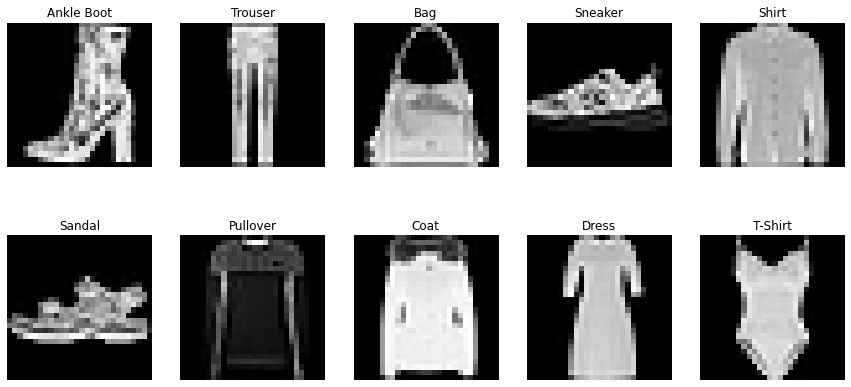

In [44]:
# Choosing one data and visualizing it
print(f"Shape of the images: {train_dataset[0][0].shape}")

Class_Name = { 0: "T-Shirt", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}
figure = plt.figure(figsize=(15, 15))
k = 0
label_list = []
while len(label_list) != 10:
    index = random.randint(0, len(train_dataset)-1)
    img, label = train_dataset[index]
    label = int(torch.argmax(label).numpy())
    if label not in label_list:
        k += 1
        label_list.append(label)
        figure.add_subplot(4, 5, k)
        plt.title(Class_Name[label])
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")  
    
plt.show()

# (B) : Making Dataset Iterable

In [17]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=True)


# (B) : Activation Functions

In [18]:
def tanh(x):
    y = (torch.exp(x) - torch.exp(-1 * x)) / (torch.exp(x) + torch.exp(-1 * x))
    return y

def softmax(x):
    x_exp = torch.exp(x)
    partition = x_exp.sum(1, keepdims=True)
    return x_exp / partition

def ReLU(x):
    k = torch.zeros_like(x)
    y = torch.maximum(x, k)
    return y

# (B) : Initialize Model parameter and Create model

In [19]:
w1 = torch.randn(784, 256, requires_grad=True)
b1 = torch.randn(1, 256, requires_grad=True)

w2 = torch.randn(256, 128, requires_grad=True)
b2 = torch.randn(1, 128, requires_grad=True)

w3 = torch.randn(128, 64, requires_grad=True)
b3 = torch.randn(1, 64, requires_grad=True)

w4 = torch.randn(64, 10, requires_grad=True)
b4 = torch.randn(1, 10, requires_grad=True)

In [20]:
def model(xb):
    global w1, b1, w2, b2, w3, b3, w4, b4
    
    y1 = torch.matmul(xb, w1) + b1
    y1 = tanh(y1)

    y2 = torch.matmul(y1, w2) + b2
    y2 = tanh(y2)

    y3 = torch.matmul(y2, w3) + b3
    y3 = tanh(y3)

    y4 = torch.matmul(y3, w4) + b4
    y4 = tanh(y4)

    yb = softmax(y4)
    return yb


# (C) : Create Loss Function

In [21]:
def BinaryCrossEntropy(y_hat, y):
    r =  (-1 / batch_size) * torch.sum(y * torch.log(y_hat) + (1 - y) * torch.log(1 - y_hat))
    return r

# (C) : Define Hyper Parameter

In [22]:
learning_rate = 1e-1
epochs = 100

# (C) : Define Train & Test Loop 

In [23]:
def train_loop(dataloader, model, loss_fn, log):
    global w1, b1, w2, b2, w3, b3, w4, b4
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, train_acc = 0, 0
    for batch, (x, y) in enumerate(dataloader):
        x = x.view(x.shape[0], -1)
        pred = model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        with torch.no_grad():
            w1 -= learning_rate * w1.grad
            b1 -= learning_rate * b1.grad
            w2 -= learning_rate * w2.grad
            b2 -= learning_rate * b2.grad
            w3 -= learning_rate * w3.grad
            b3 -= learning_rate * b3.grad
            w4 -= learning_rate * w4.grad
            b4 -= learning_rate * b4.grad
            w1.grad.zero_()
            b1.grad.zero_()
            w2.grad.zero_()
            b2.grad.zero_()
            w3.grad.zero_()
            b3.grad.zero_()
            w4.grad.zero_()
            b4.grad.zero_()
            
        train_loss += loss.item()
        train_acc += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
            
    train_loss /= num_batches
    train_acc /= size

    log['train_loss'].append(train_loss)
    log['train_acc'].append(train_acc)
    print(f"Train Result: \n Accuracy: {(100*train_acc):>0.1f}%, Avg Train loss: {train_loss:>8f} \n")
    
    
def valid_loop(dataloader, model, loss_fn, log):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    valid_loss, valid_acc = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x = x.view(x.shape[0], -1)
            pred = model(x)
            valid_loss += loss_fn(pred, y).item()
            valid_acc += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

    valid_loss /= num_batches
    valid_acc /= size
    
    log['valid_loss'].append(valid_loss)
    log['valid_acc'].append(valid_acc)
    print(f"Validation Result: \n Accuracy: {(100*valid_acc):>0.1f}%, Avg Validation loss: {valid_loss:>8f} \n")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, test_acc = 0, 0

    with torch.no_grad():
        for x, y in dataloader:
            x = x.view(x.shape[0], -1)
            pred = model(x)
            test_loss += loss_fn(pred, y).item()
            test_acc += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

    test_loss /= num_batches
    test_acc /= size
    print(f"Test Result: \n Accuracy: {(100*test_acc):>0.1f}%, Avg Test loss: {test_loss:>8f} \n")


# (C) : Training Process

In [24]:
log = {'train_loss':[], 'valid_loss' : [], 'train_acc' : [], 'valid_acc' : []}
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn = BinaryCrossEntropy, log = log)
    valid_loop(valid_loader, model, loss_fn = BinaryCrossEntropy, log = log)
print("Done!")

Epoch 1
-------------------------------
Train Result: 
 Accuracy: 26.0%, Avg Train loss: 3.045340 

Validation Result: 
 Accuracy: 38.3%, Avg Validation loss: 2.697116 

Epoch 2
-------------------------------
Train Result: 
 Accuracy: 43.7%, Avg Train loss: 2.513378 

Validation Result: 
 Accuracy: 48.6%, Avg Validation loss: 2.351732 

Epoch 3
-------------------------------
Train Result: 
 Accuracy: 52.2%, Avg Train loss: 2.279683 

Validation Result: 
 Accuracy: 54.5%, Avg Validation loss: 2.224799 

Epoch 4
-------------------------------
Train Result: 
 Accuracy: 56.6%, Avg Train loss: 2.176267 

Validation Result: 
 Accuracy: 57.4%, Avg Validation loss: 2.156430 

Epoch 5
-------------------------------
Train Result: 
 Accuracy: 59.4%, Avg Train loss: 2.113694 

Validation Result: 
 Accuracy: 60.7%, Avg Validation loss: 2.085773 

Epoch 6
-------------------------------
Train Result: 
 Accuracy: 61.1%, Avg Train loss: 2.074428 

Validation Result: 
 Accuracy: 61.4%, Avg Validati

Train Result: 
 Accuracy: 79.6%, Avg Train loss: 1.758141 

Validation Result: 
 Accuracy: 78.7%, Avg Validation loss: 1.779154 

Epoch 50
-------------------------------
Train Result: 
 Accuracy: 79.5%, Avg Train loss: 1.757447 

Validation Result: 
 Accuracy: 78.5%, Avg Validation loss: 1.784920 

Epoch 51
-------------------------------
Train Result: 
 Accuracy: 79.7%, Avg Train loss: 1.752694 

Validation Result: 
 Accuracy: 78.6%, Avg Validation loss: 1.781930 

Epoch 52
-------------------------------
Train Result: 
 Accuracy: 79.7%, Avg Train loss: 1.752213 

Validation Result: 
 Accuracy: 79.0%, Avg Validation loss: 1.780765 

Epoch 53
-------------------------------
Train Result: 
 Accuracy: 80.0%, Avg Train loss: 1.744657 

Validation Result: 
 Accuracy: 78.7%, Avg Validation loss: 1.775918 

Epoch 54
-------------------------------
Train Result: 
 Accuracy: 80.2%, Avg Train loss: 1.742127 

Validation Result: 
 Accuracy: 79.0%, Avg Validation loss: 1.772772 

Epoch 55
------

Train Result: 
 Accuracy: 84.2%, Avg Train loss: 1.648288 

Validation Result: 
 Accuracy: 81.5%, Avg Validation loss: 1.728097 

Epoch 98
-------------------------------
Train Result: 
 Accuracy: 84.0%, Avg Train loss: 1.649678 

Validation Result: 
 Accuracy: 81.4%, Avg Validation loss: 1.727040 

Epoch 99
-------------------------------
Train Result: 
 Accuracy: 84.3%, Avg Train loss: 1.647597 

Validation Result: 
 Accuracy: 81.5%, Avg Validation loss: 1.722351 

Epoch 100
-------------------------------
Train Result: 
 Accuracy: 84.4%, Avg Train loss: 1.642568 

Validation Result: 
 Accuracy: 81.5%, Avg Validation loss: 1.719429 

Done!


# (C) : Plot The Result

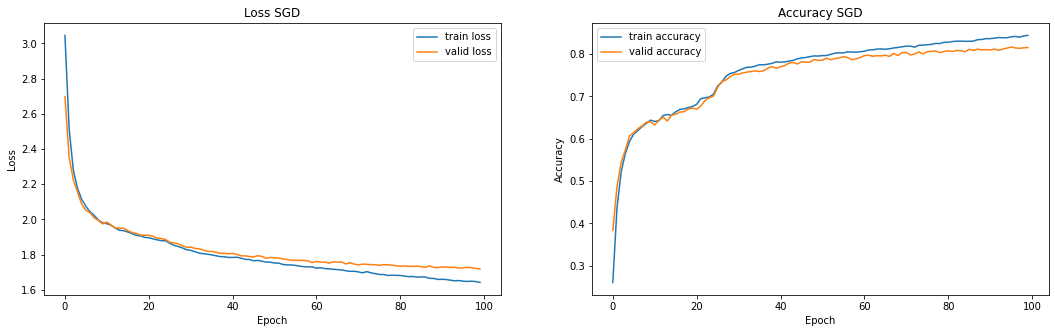

In [25]:
n_epochs = [*range(epochs)]
plt.figure(figsize=(18,5))
plt.subplot(121)
plt.plot(n_epochs, log['train_loss'])
plt.plot(n_epochs, log['valid_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title('Loss SGD')
plt.legend(['train loss', 'valid loss'])
plt.subplot(122)
plt.plot(n_epochs, log['train_acc'])
plt.plot(n_epochs, log['valid_acc'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title('Accuracy SGD')
plt.legend(['train accuracy', 'valid accuracy'])

# (D) : Evaluate model On Test data

In [26]:
print('Accuracy On Test Data Is:')
test_loop(test_loader, model, loss_fn = BinaryCrossEntropy)

Accuracy On Test Data Is:
Test Result: 
 Accuracy: 80.7%, Avg Test loss: 1.735285 



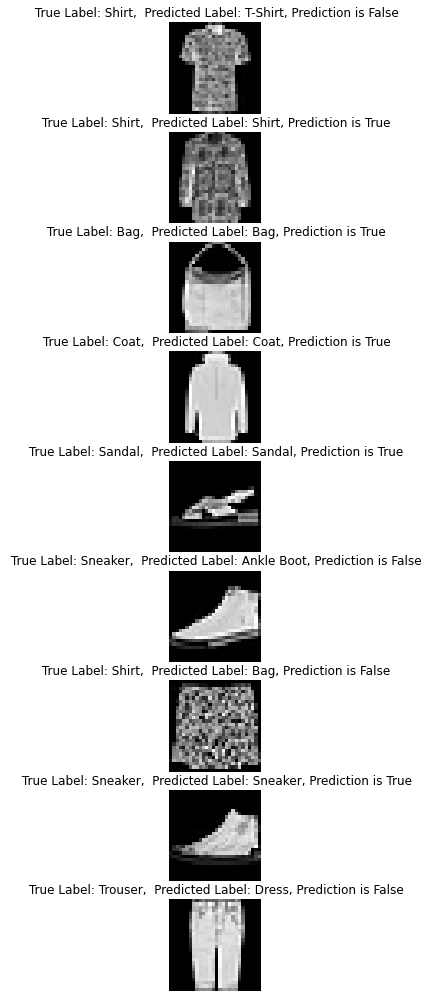

In [ ]:
figure = plt.figure(figsize=(20, 20))
loss_fn = BinaryCrossEntropy
for j in range(9):
    index = random.randint(0, len(test_dataset)-1)
    x, label = test_dataset[index]
    label = label.unsqueeze(0)
    test_loss , test_acc = 0 , 0 
    with torch.no_grad():                       
        img = img.view(x.shape[0], -1)
        pred = model(img)

    figure.add_subplot(9, 1, j+1)
    plt.title(f" True Label: {Class_Name[label.argmax().item()]},  Predicted Label: {Class_Name[pred.argmax().item()]}, Prediction is {Class_Name[label.argmax().item()] == Class_Name[pred.argmax().item()]}  ")
    plt.axis("off")
    plt.imshow(x.squeeze(), cmap="gray")